In [6]:
from langchain.chat_models import init_chat_model
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from dotenv import load_dotenv
load_dotenv()
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [7]:
@tool
def get_stock_price(symbol: str) -> float:
    '''Return the current price of a stock given the stock symbol
    :param symbol: stock symbol
    :return: current price of the stock
    '''
    return {
        "MSFT": 200.3,
        "AAPL": 100.4,
        "AMZN": 150.0,
        "RIL": 87.6
    }.get(symbol, 0.0)

tools = [get_stock_price]

llm = init_chat_model("google_genai:gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

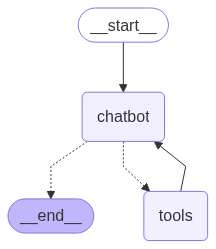

In [13]:
def chatbot(state: State) -> State:
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)

builder.add_node("chatbot", chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
builder.add_edge("tools", "chatbot")
graph = builder.compile(checkpointer=memory)

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config1 = { 'configurable': { 'thread_id': '1'} }
config2 = { 'configurable': { 'thread_id': '2'} }

In [ ]:
from langsmith import traceable

@traceable
def call_graph(query: str, config: dict):
    state = graph.invoke({"messages": [{"role": "user", "content": query}]}, config=config)
    return state["messages"][-1].content

@traceable
def get_messages_by_thread(config: dict):
    if "configurable" not in config or "thread_id" not in config["configurable"]:
        raise ValueError("Missing 'thread_id' in config['configurable']")
    state = memory.get(config)
    if not state:
        raise ValueError(f"No state found for thread_id: {config['configurable']['thread_id']}")

    return state["channel_values"]["messages"]

call_graph("I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?", config1)
get_messages_by_thread(config1)

[HumanMessage(content='I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?', additional_kwargs={}, response_metadata={}, id='ad0c102d-37c8-4eb0-ade5-0c6703f74f0c'),
 AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_stock_price', 'arguments': '{"symbol": "MSFT"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--881c2779-47ee-470d-8afb-fdb0ba245309-0', tool_calls=[{'name': 'get_stock_price', 'args': {'symbol': 'AMZN'}, 'id': '1ecbc2e0-587a-42d4-a78d-2f5f622514fd', 'type': 'tool_call'}, {'name': 'get_stock_price', 'args': {'symbol': 'MSFT'}, 'id': '8ede4892-851d-4a2a-88cc-a5bcdaca041b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 64, 'output_tokens': 16, 'total_tokens': 80, 'input_token_details': {'cache_read': 0}}),
 ToolMessage(content='150.0', name='get_stock_price', id='e1ea15da-f827-4cc

In [23]:
call_graph("Tell me the current price of 5 MSFT stocks and add it to previous total",  config2)
get_messages_by_thread(config2)

[HumanMessage(content='Tell me the current price of 5 MSFT stocks and add it to previous total', additional_kwargs={}, response_metadata={}, id='865b3a07-d680-43f7-9518-1a7cd60ef7b4'),
 AIMessage(content="I can get you the current price of one MSFT stock, but I can't calculate the price of 5 stocks or add it to a previous total. Would you like me to get the current price of one MSFT stock?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--77ada1e8-333e-4e2b-b383-fddcacdc5367-0', usage_metadata={'input_tokens': 53, 'output_tokens': 49, 'total_tokens': 102, 'input_token_details': {'cache_read': 0}})]